#### First we fit the model with the best parameters we found

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Telco_Customer_Churn_clean.csv')

X = df.drop('Churn', axis=1)
y = df['Churn']

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [3]:
params = {
    'gamma':1.350373,
    'learning_rate':0.123482,
    'max_depth':2,
    'subsample':0.533326
}

In [4]:
import xgboost as xgb

In [5]:
xgb_model = xgb.XGBClassifier(
    n_estimators = 1000,
    eval_metric = 'auc',
    verbosity = 1,
    early_stopping_rounds = 30,
    objective = 'binary:logistic'
)

In [6]:
xgb_model.set_params(**params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=1.350373, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.123482, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [7]:
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=1.350373, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.123482, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

#### Xgboost built-in feature importance
- By gain

In [8]:
feat_imp_gain = xgb_model.get_booster().get_score(importance_type='gain')

In [9]:
keys = list(feat_imp_gain.keys())
values = list(feat_imp_gain.values())

df_feat_imp_gain = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by='score', ascending= False)
df_feat_imp_gain

,score
InternetService_Fiber optic,99.428482
Contract_Two year,56.688511
Contract_One year,42.093170
PaymentMethod_Electronic check,38.063282
InternetService_No,35.790188
tenure,32.617435
PaperlessBilling,13.591837
OnlineSecurity_Yes,13.098040
TechSupport_Yes,12.815236
Dependents,9.381721


#### Plot the 10 most important features

<Axes: title={'center': 'Feature importance by gain'}>

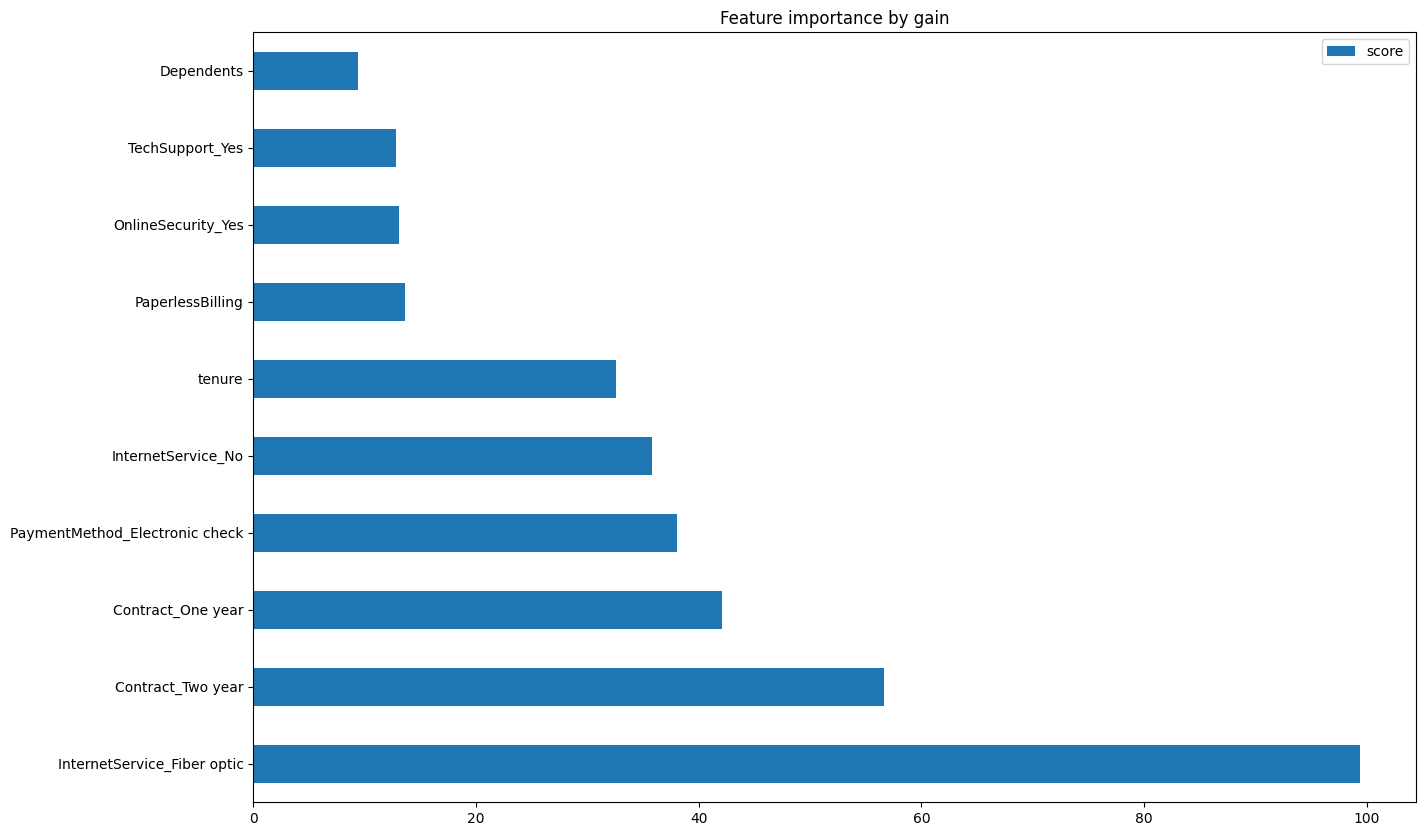

In [10]:
df_feat_imp_gain.nlargest(10, columns='score').plot(kind='barh',figsize=(15,10), title='Feature importance by gain')

- weight

In [11]:
feat_imp_weight = xgb_model.get_booster().get_score(importance_type='weight')

keys = list(feat_imp_weight.keys())
values = list(feat_imp_weight.values())

df_feat_imp_weight = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by='score', ascending= False)
df_feat_imp_weight

,score
TotalCharges,57.0
MonthlyCharges,56.0
tenure,50.0
Contract_Two year,13.0
OnlineSecurity_Yes,10.0
InternetService_No,9.0
PaymentMethod_Electronic check,9.0
PhoneService,9.0
PaperlessBilling,9.0
MultipleLines_Yes,9.0


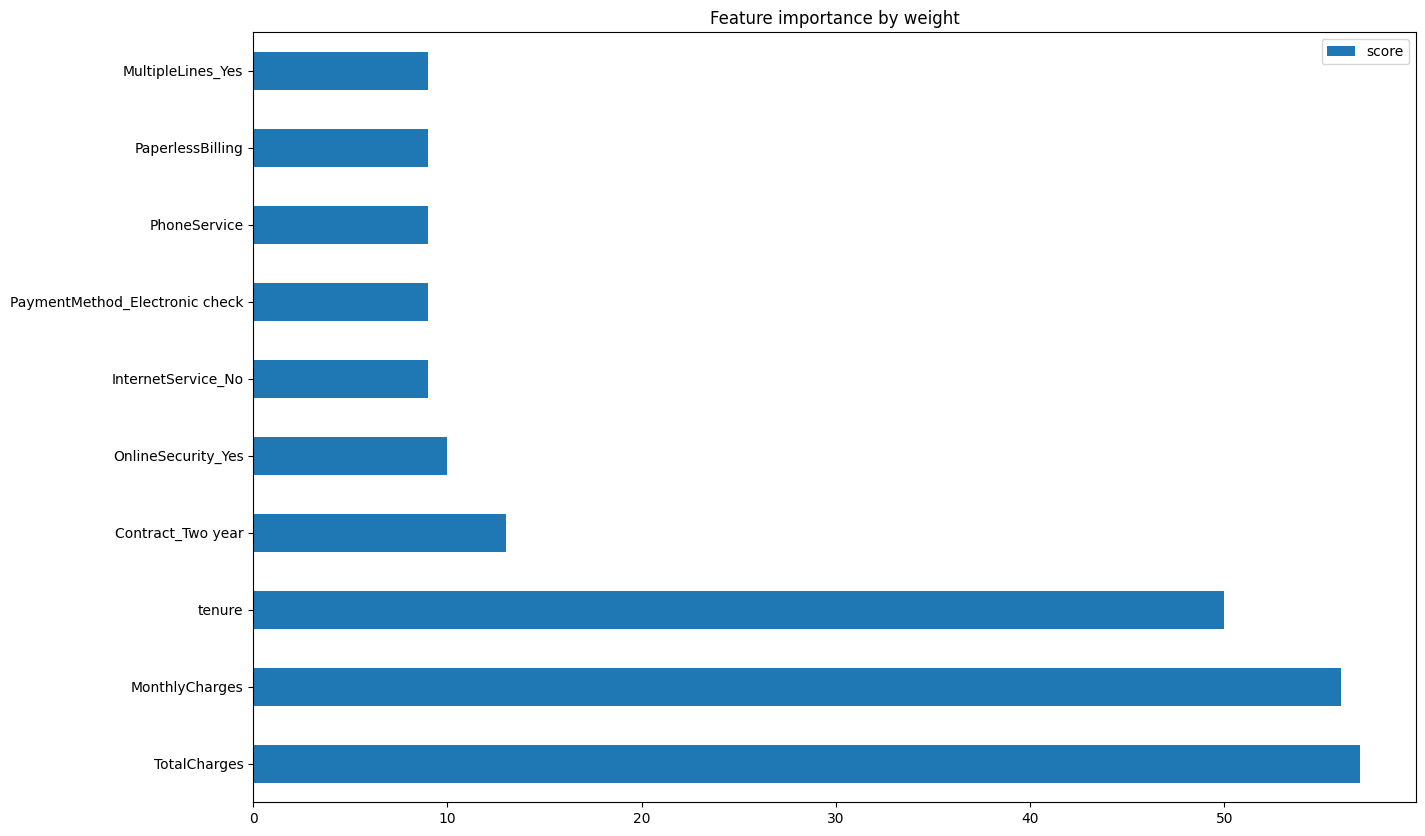

In [12]:
df_feat_imp_weight.nlargest(10, columns='score').plot(kind='barh',figsize=(15,10), title='Feature importance by weight')
plt.show()

## Feature importance using SHAP

In [13]:
import shap

/home/harry/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

#### Let's see if shap values add up to the predictions

In [15]:
import numpy as np

shap_sum = shap_values.sum(axis = 1)+explainer.expected_value
shap_sum_prob = 1/(1 + np.exp(-1 * shap_sum))
y_test_prob = xgb_model.predict_proba(X_test)[:,1]

df_shap_sum = pd.DataFrame({
    'SHAP Sum': shap_sum_prob,
    'predicted probability':y_test_prob
})
df_shap_sum.sample(10)

,SHAP Sum,predicted probability
975,0.434722,0.434722
208,0.242406,0.242406
1119,0.605414,0.605414
1350,0.018130,0.018130
194,0.074478,0.074478
663,0.616571,0.616571
1001,0.356387,0.356387
1249,0.432998,0.432998
896,0.028833,0.028833
164,0.026678,0.026678


In [16]:
# check using numpy allclose function
np.allclose(shap_sum_prob, y_test_prob)

True

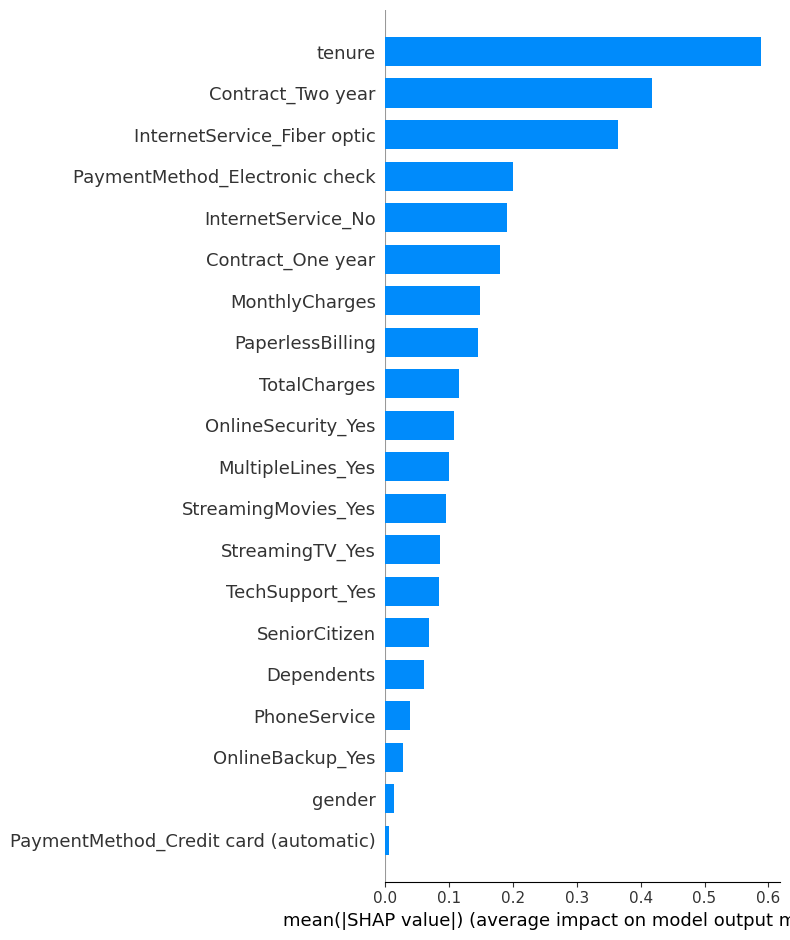

In [17]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The top 4 features by F statistic we found by ANOVA F-Test were: `tenure, InternetService_Fiber optic, Contract_Two year, PaymentMethod_Electronic check`. These are also the top 4 features which are contributing the most as we see in the bar plot above.

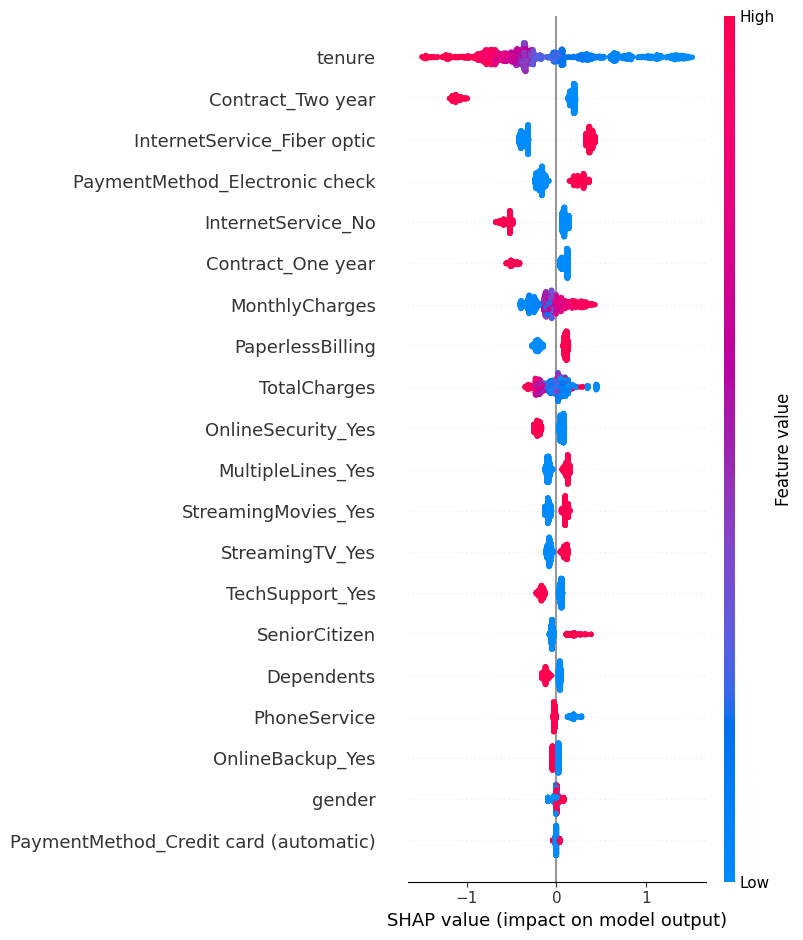

In [18]:
shap.summary_plot(shap_values, X_test)

Let us look at the scatter plot of SHAP values for the tenure column

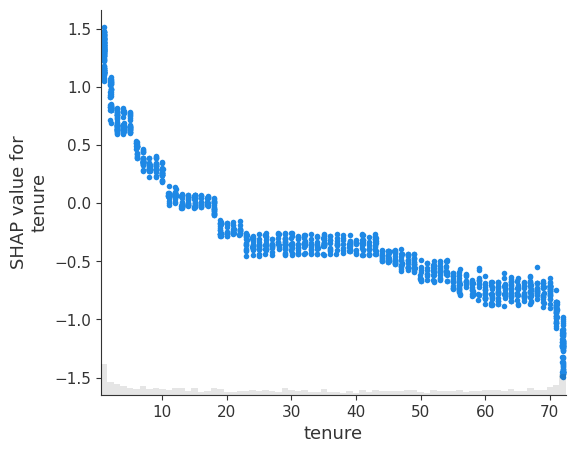

In [19]:
tenure_idx = df.columns.get_loc('tenure')
shap.plots.scatter(explainer(X_test)[:,'tenure'])

We see from scatter plot above that for most values of tenure the shap values are near 0. But at the extreme values of tenure we get shap values away from 0.
For tenure near 0 we get shap values in the range 1 to 1.5. And for tenure near 70 we get negative shap values in the range -1 to -1.5

Now let's color the scatter plot above by the feature with which it has highest interaction

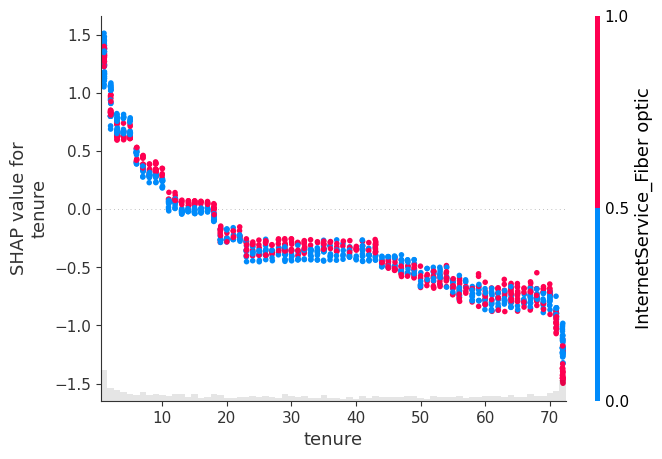

In [20]:
shap.plots.scatter(explainer(X_test)[:,'tenure'], color=explainer(X_test))

`InternetService_Fiber optic` was selected as the feature with highest interaction with `tenure`. We do not see any pattern. We see high and low values of `InternetService_Fiber optic` for all values of tenure.